#Creating Celebrities You've Never Seen

Celebrities are often the talk of society. Their voices are projected through every website and advertisement, and their photos plastered across magazines and billboards. And, rather unfortunately, it is that second reason which makes them useful within this project. With so many abundant photos, we are able to have a datascientists dream - an abundant, clean, large dataset. Using data downloaded from The Chinese University of Hong Kong found [here](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), we are able to take over 204,000 images of celebrity faces and apply them in any which manner. 

In this instance, we are using this real world dataset under the context of a GANs, or a Generative Adversarial Network, to create faces that never existed until the completion of this notebook. 

##How Will We Generate These Faces?

The method used in generating these faces is a GANs, or a Generative Adversarial Network, specifically in this context a DCGANs, or a Deep Convolutional Generative Adversarial Network. 

In general, a GAN's is nothing more than a relationship between two neural networks. Their relationship


##Downloading the Data

Our first step is to download the data. Considering the scale of the data (204,000 images) and our use of Google Colab, it is best practice to upload the .zip file to our Google Drive before unzipping in this notebook. 

The first step to this is mounting our Google Drive to our Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We then navigate to the directory containing all our images

In [1]:
ls

drive/  sample_data/


In [2]:
cd drive/

/content/drive


In [3]:
ls

MyDrive/  Shareddrives/


In [4]:
cd MyDrive/

/content/drive/MyDrive


In [5]:
ls


 Celeb_Images.zip
'Colab Notebooks'/
'Copy of PRD Worksheet Example.gdoc'
'Copy of Risks & Mitigations - SPD 2.1.gdoc'
'Copy of Senior Intensive Proposal Template.gdoc'
'Copy of SPD 2.1 and 2.2 slides (1).gslides'
'Copy of SPD 2.1 and 2.2 slides (2).gslides'
'Copy of SPD 2.1 and 2.2 slides (3).gslides'
'Copy of SPD 2.1 and 2.2 slides (4).gslides'
'Copy of SPD 2.1 and 2.2 slides (5).gslides'
'Copy of SPD 2.1 and 2.2 slides.gslides'
'Deep Learning.gdoc'
'Domain Literacy Response.gdoc'
'Ethics Final Presentation.gslides'
 img_align_celeba/
'Ltr from President Pitchford.gdoc'
'Ltr from President Pitchford.pdf'
 Make_School_Uploads/
'ML DL Book Notes.gdoc'
 MLP-Fire-Detection-Tutorial/
 Omni-Document.gdoc
'Personal Statement - Intensive.gdoc'
'Real Ethics Final Presentation.gslides'
'SPD 2.1.gdoc'
'Untitled document.gdoc'


Once we havigate to our proper directory, we then unzip the file. 
>**Note**: This will take approximately 2 hours, but is only required once

In [25]:
#!unzip Celeb_Images.zip

#Preparing to Code

Before we prepare to code our, we must import our required libraries.
 - Numpy: 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from tensorflow.keras.optimizers import Nadam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/

/content/drive


In [4]:
ls

MyDrive/  Shareddrives/


In [5]:
cd MyDrive/

/content/drive/MyDrive


In [6]:
ls

 Celeb_Images.zip
'Colab Notebooks'/
'Copy of PRD Worksheet Example.gdoc'
'Copy of Risks & Mitigations - SPD 2.1.gdoc'
'Copy of Senior Intensive Proposal Template.gdoc'
'Copy of SPD 2.1 and 2.2 slides (1).gslides'
'Copy of SPD 2.1 and 2.2 slides (2).gslides'
'Copy of SPD 2.1 and 2.2 slides (3).gslides'
'Copy of SPD 2.1 and 2.2 slides (4).gslides'
'Copy of SPD 2.1 and 2.2 slides (5).gslides'
'Copy of SPD 2.1 and 2.2 slides.gslides'
'Deep Learning.gdoc'
'Domain Literacy Response.gdoc'
'Ethics Final Presentation.gslides'
 img_align_celeba/
'Ltr from President Pitchford.gdoc'
'Ltr from President Pitchford.pdf'
 Make_School_Uploads/
'ML DL Book Notes.gdoc'
 MLP-Fire-Detection-Tutorial/
 Omni-Document.gdoc
'Personal Statement - Intensive.gdoc'
'Real Ethics Final Presentation.gslides'
'SPD 2.1.gdoc'
'Untitled document.gdoc'


In [7]:
cd img_align_celeba

/content/drive/MyDrive/img_align_celeba


In [8]:
ls

img_align_celeba/


In [9]:
ls

img_align_celeba/


We follow through into our folder containing all 204,000 images

In [22]:
number_images = 1200
batch_size = 128
latent_dim = 100
number_epochs = 10
img_shape = (128, 128, 3)

In [11]:
 data_directory = './img_align_celeba/'
images = os.listdir(data_directory)
images = images[:number_images]

Here we set the amount of images we want to train (number_images), the amount of iterations we want our GANs to run on (epochs), and the defined shape of the image as well as batch_size

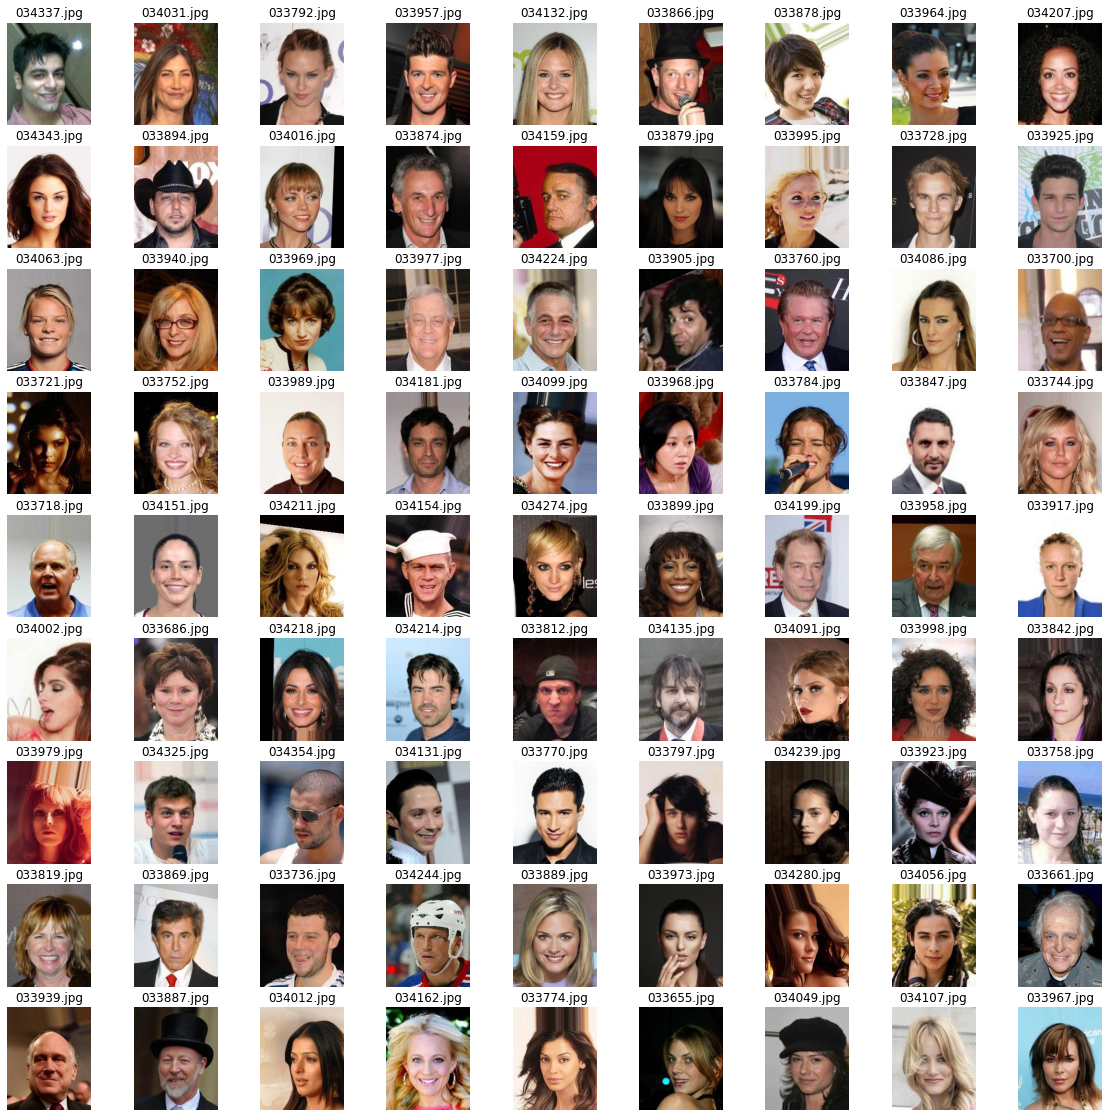

In [12]:
plt.figure(figsize=(20,20))
for i, name in enumerate(images[:81]):
    plt.subplot(9, 9, i + 1)
    img = plt.imread(data_directory + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

Here we get an idea of the image dataset we are working with. These images are high quality, high pixelation, headshots of multiple celebrities containing men, women, and multiple ethnicities. This is a good diversified dataset. 

In [26]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_directory + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    X = X / 255
    return X

dataset = get_data(images)

After cleaning our images, we can now start defining the components of our GANs. First is the discriminator, which will essentially tell apart fake, generated data from real data. 

In [16]:
def define_discriminator(in_shape=(128,128,3)):

    model = Sequential()

    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())

    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))

    opt = Nadam(learning_rate=0.002, beta_1=0.5)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

We start defining our discriminator with the input shape as a parameter of the function, which is of size 128 by 128. We continue with a Sequential model setup, downsizing our sampled image from 128 by 128 dimension down to an 8 by 8 image, using LeakyReLU as our activation function (a common activation function for GANs). 

We then take our 8 by 8 map and flatten it for our classifier, since 1-dimensional array's are the input size for neural networks. 

Next, we implement our optimizer, which is Nadam, a variation of the Adam optimizer with a special gradient decent to improve convergence. 

In [17]:
def define_generator(latent_dim):
    model = Sequential()
  
    n_nodes = 128 * 8 * 8

    model.add(Dense(n_nodes, input_dim=latent_dim))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Reshape((8, 8, 128)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))

    return model

#input of Generator
def generate_latent_points(latent_dim, n_samples):

    x_input = randn(latent_dim * n_samples)

    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Generating "n" fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):

    x_input = generate_latent_points(latent_dim, n_samples)

    X = g_model.predict(x_input)

    y = np.zeros((n_samples, 1))
    return X, y

Now, we can start defining our generator. Essentially, what we will do here is the reverse of our discriminator, using the first layers to transpose our discriminator output. By the 4th layer, we are back to our original 128 by 128 shape, again using LeakyReLU as our activation function. 

Once we have our model, we then define our generator's input, generating points in our latent space and reshaping as a batch to input into our network. 

Once that is done, we then define the function to generate our fake samples to trick our discriminator. 



In [18]:
def define_gan(g_model, d_model):

    d_model.trainable = False

    model = Sequential()

    model.add(g_model)

    model.add(d_model)
  
    opt = Nadam(learning_rate=0.002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Getting our Real samples
def get_real_samples(dataset, n_samples):

    ix = randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]

    y = np.ones((n_samples, 1))
    return X, y

# Showing Generated Images
def show_generated(generated,epoch, n=5):

    plt.figure(figsize=(10,10))

    for i in range(n * n):

        plt.subplot(n, n, i + 1)

        plt.imshow(generated[i])

        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

# Evaluate the discriminator and plot images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):

    X_real, y_real = get_real_samples(dataset, n_samples)

    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))

    show_generated(x_fake, epoch)

This is where we put it all together and create our GANs. We create a function for gans with the parameters being our generator and discriminator. We set the weights of our GANs model to be untrainable since it includes our discriminator. We use another sequential model, connecting our discriminator and generator together as "layers" to our GANs. We then proceed with compiling our model with our Nadam optimizer and specific parameters such as learning rate and our decay rate.

Next is our function for retrieving real samples, setting them into a dataset and placing them into class 1 for True (class 0 is for False). 

Following is our function for generating and plotting our images in a 10 by 10 plot, and our performance evaluator. This takes in our real samples, evaluates our discriminator on the real examples, then takes in fake examples and feeds them into our discriminator, and then summaries our performance. 



In [19]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, number_epochs=100, n_batch=128):

    bat_per_epo = int(dataset.shape[0] / n_batch)

    half_batch = int(n_batch / 2)

    start = time.time()

    for i in range(number_epochs):
        
        for j in range(bat_per_epo):

            X_real, y_real = get_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(latent_dim, n_batch)

            y_gan = np.ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))

        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(number_epochs, (time.time()-start)))

Now, we can train our gans and get some results. Here we we iterate through the length of our epochs and batches across our training set, randomly selecting samples, updating our discriminator weights, generating fake samples, and updating our discriminator wieghts. We then prepare our input for the generator, creating invesrted labels for the fake samples so they appear real, and update our generator through our discriminators error. Towards the end of the function, we summarize our loss and evaluate how well our gans performed on this epoch. 

Epoch: 1,  Loss: D_real = 1671.617, D_fake = 68.734,  G = 683.025
Epoch: 2,  Loss: D_real = 0.000, D_fake = 43.523,  G = 0.000
Epoch: 3,  Loss: D_real = 0.101, D_fake = 0.242,  G = 4.651
Epoch: 4,  Loss: D_real = 3.616, D_fake = 32.695,  G = 0.901
Epoch: 5,  Loss: D_real = 0.409, D_fake = 0.534,  G = 10.751
Epoch: 6,  Loss: D_real = 1.242, D_fake = 4.092,  G = 3.724
Epoch: 7,  Loss: D_real = 0.043, D_fake = 1.438,  G = 10.386
Epoch: 8,  Loss: D_real = 0.777, D_fake = 1.564,  G = 8.509
Epoch: 9,  Loss: D_real = 0.758, D_fake = 0.839,  G = 5.355
Epoch: 10,  Loss: D_real = 0.919, D_fake = 0.856,  G = 6.717
>Accuracy [real: 72%, fake: 100%]


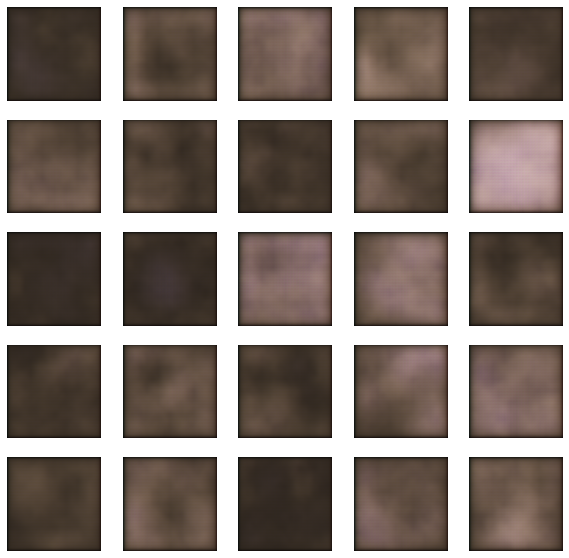

Total time for training 10 epochs is 12621.76250076294 sec


In [23]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan, dataset, latent_dim, number_epochs, batch_size)
